In [1]:
# Install the necessary libraries
!pip install transformers PyPDF2 scikit-learn matplotlib

import PyPDF2
import re
import torch
from transformers import AutoTokenizer, AutoModel
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 232.6/232.6 kB 3.5 MB/s eta 0:00:00


In [5]:
import zipfile
import os

# File path for the uploaded zip file
zip_file_path = '/content/archive-2.zip'
extracted_folder_path = '/mnt/data/extracted_documents'

# Extracting the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_folder_path)

# Listing the files extracted
extracted_files = os.listdir(extracted_folder_path)
extracted_files

['archive-2', '__MACOSX']

In [6]:
# Updating the extracted folder path to the new directory
extracted_folder_path = os.path.join(extracted_folder_path, 'archive-2')

# Listing the files in the new directory
extracted_files = os.listdir(extracted_folder_path)
extracted_files

['kaggle_income.csv', 'Income_Methodology.pdf', 'Kaggle_deffs.pdf']

In [10]:
def extract_text_from_pdf(file_path):
    """Extracts text from a given PDF file."""
    text = ''
    with open(file_path, 'rb') as file:
        reader = PyPDF2.PdfReader(file)
        for page in reader.pages:
            text += page.extract_text()
    return text

# Extracting text from each PDF file
pdf_texts = {}
for file in extracted_files:
    if file.endswith('.pdf'):
        file_path = os.path.join(extracted_folder_path, file)
        pdf_texts[file] = extract_text_from_pdf(file_path)

# Displaying the first 500 characters of each extracted text to verify
for file, text in pdf_texts.items():
    print(f"First 500 characters in {file}:")
    print(text[:500])
    print("\n---\n")


First 500 characters in Income_Methodology.pdf:
GOLDEN OAK RESEARCH  
August 13, 2017  
 
 
 
 
Standard Income Table:   
Low  (𝐿) High   (𝐻)  Midpoint  (𝐼) Range (𝑅) 
$0 $10,000   $5,000  $10,000  
$10,000  $14,999   $12,500  $4,999  
$15,000  $19,999   $17,500  $4,999  
$20,000  $24,999   $22,500  $4,999  
$25,000  $29,999   $27,500  $4,999  
$30,000  $34,999   $32,500  $4,999  
$35,000  $39,999   $37,500  $4,999  
$40,000  $44,999   $42,500  $4,999  
$45,000  $49,999   $47,500  $4,999  
$50,000  $59,999   $55,000  $9,999  
$60,000  $74,999

---

First 500 characters in Kaggle_deffs.pdf:
Golden Oak Research Group LLC. 1 
 
GOLDEN OAK RESEARCH  
August 5, 2017  
 
Contents  
Definitions  ................................ ................................ ................................ ................................ ................................ ...... 2 
1. id ................................ ................................ ................................ ......................

In [11]:
import re

def clean_and_normalize_text(text):
    """Cleans and normalizes the extracted text."""
    # Removing special characters and numbers
    text = re.sub(r'[^A-Za-z\s]', '', text)
    # Replacing multiple whitespaces with a single space
    text = re.sub(r'\s+', ' ', text)
    # Converting text to lowercase
    text = text.lower().strip()
    return text

# Cleaning and normalizing the extracted texts
cleaned_texts = {file: clean_and_normalize_text(text) for file, text in pdf_texts.items()}

# Displaying the first 500 characters of each cleaned and normalized text
for file, text in cleaned_texts.items():
    print(f"First 500 characters in cleaned {file}:")
    print(text[:500])
    print("\n---\n")


First 500 characters in cleaned Income_Methodology.pdf:
golden oak research august standard income table low high midpoint range definition suppose let the income be distinct numbers in however since the range of the grouped frequencies are not uniform we must map m mmin definition now s uppose let the income be distinct numbers in such that the hermite polynomial and approximates theorem if and partitioned into intervals district numbers the hermite polynomial is

---

First 500 characters in cleaned Kaggle_deffs.pdf:
golden oak research group llc golden oak research august contents definitions id statecode statename stateab county city place type primary zip code area code aland awater lat lon mean median stdev households license copyright license citing publications questions and sourses contact works cited for the full dataset please visit us at website httpswwwgoldenoakresearchcom coupon buygetfree golden oak research group llc definitions id type character description the id of t

In [12]:
from transformers import AutoTokenizer, AutoModel
import torch

def get_embeddings(text, model, tokenizer):
    """Generates embeddings for a given text using the specified model and tokenizer."""
    # Encoding the text
    inputs = tokenizer(text, return_tensors='pt', truncation=True, max_length=512, padding='max_length')
    # Generating outputs using the model
    outputs = model(**inputs)
    # Taking the mean of the last hidden states to get the sentence embedding
    embeddings = outputs.last_hidden_state.mean(dim=1)
    return embeddings

# Using the 'bert-base-uncased' model for embeddings
model_name = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Generating embeddings for each document
embeddings = {}
for file, text in cleaned_texts.items():
    embeddings[file] = get_embeddings(text, model, tokenizer)

# Displaying the shape of the embeddings to confirm
for file, embedding in embeddings.items():
    print(f"Embedding shape for {file}: {embedding.shape}")


tokenizer_config.json:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Embedding shape for Income_Methodology.pdf: torch.Size([1, 768])
Embedding shape for Kaggle_deffs.pdf: torch.Size([1, 768])


In [14]:
# Flattening the embeddings into 2D
embeddings_2d = np.array([embedding.squeeze().detach().numpy().flatten() for embedding in embeddings.values()])

# Performing K-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(embeddings_2d)

# The cluster labels for each document
cluster_labels = kmeans.labels_

# Displaying the cluster assignment for each document
for i, file in enumerate(embeddings.keys()):
    print(f"Document '{file}' is in Cluster {cluster_labels[i]}")



Document 'Income_Methodology.pdf' is in Cluster 0
Document 'Kaggle_deffs.pdf' is in Cluster 1


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


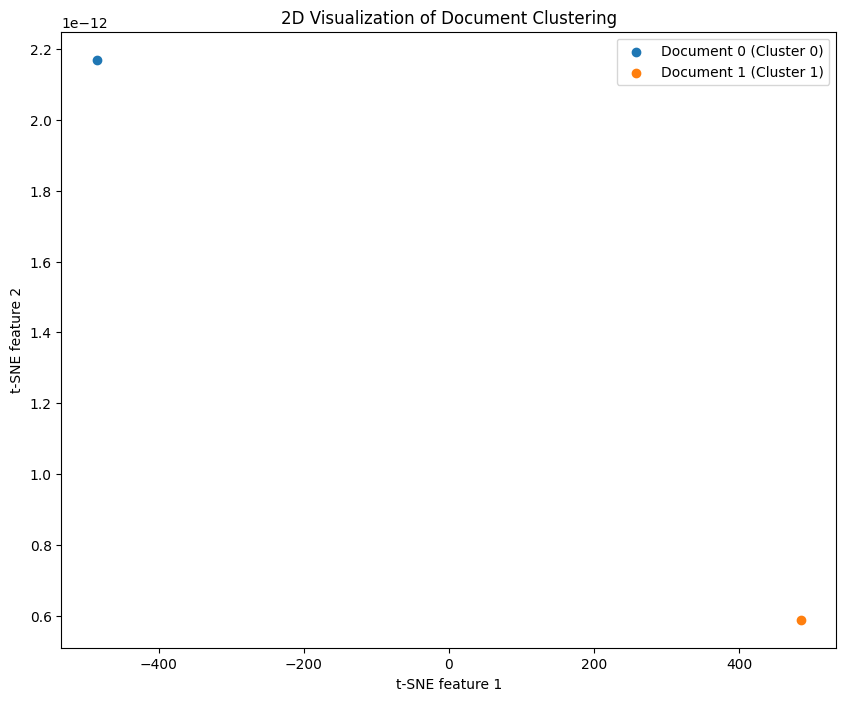

In [18]:
from sklearn.manifold import TSNE

# Ensure embeddings are flattened to 2D (if embeddings were previously 3D)
embeddings_2d_array = np.array([embedding.squeeze().detach().numpy().flatten() for embedding in embeddings.values()])

# t-SNE with adjusted perplexity
tsne = TSNE(n_components=2, random_state=0, perplexity=1)  # Perplexity is set to 1 for very small datasets
embeddings_2d = tsne.fit_transform(embeddings_2d_array)

# Plotting the embeddings with cluster labels
plt.figure(figsize=(10, 8))
for i, (x, y) in enumerate(embeddings_2d):
    plt.scatter(x, y, label=f'Document {i} (Cluster {cluster_labels[i]})')

plt.xlabel('t-SNE feature 1')
plt.ylabel('t-SNE feature 2')
plt.title('2D Visualization of Document Clustering')
plt.legend()
plt.show()
